# Using BERT to Identify Bill Hardy (Binary Classification of Pages) [WIP]

Now that K-means clustering seems to indicate that some of the narrators can be inferred from the pages, we can attempt to use a language model to predict whether a page belongs to a given narrator. 

Let's start with a binary classification to **predict if sentences belong or not to Bill Hardy**.

<img src="https://glthr.com/cj/characters/bill-min.jpg" alt="drawing" width="400"/>

In [1]:
%%capture

# make logs less verbose
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# suppress UnparsedFlagAccessError warning
import sys
from absl import flags

sys.argv = ["preserve_unused_tokens=False"]
flags.FLAGS(sys.argv)

# suppress Pandas Future Warning (deprecation of DataFrame.swapaxes)
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

## Process data

In [2]:
import pandas as pd

df = pd.read_json("./data/jawbone.json")

Augment the data with the label: `True` for Bill Hardy, `False` otherwise.

In [3]:
import json

f = open("./data/unofficial_solution.json")
possible_solutions = json.load(f)
f.close()


def is_bill(id):
    for key, ids in possible_solutions.items():
        if id in ids:
            return key == "Bill Hardy"
    return None


df = df.astype({"text": "string"})
df["narrator"] = df["page"].apply(lambda x: is_bill(x))
df

,page,text,narrator
0,1,I sit down alone at the appointed table and ta...,True
1,2,I plunged for the last time. The few remaining...,False
2,3,"At my meeting with Clement yesterday, he had b...",False
3,4,And I really think I would have preferred the ...,True
4,5,I hated my eye for being caught by what didn’t...,False
...,...,...,...
95,96,Now I think I will try a cup of what they inso...,True
96,97,To have slept and to wake right up surrounded ...,False
97,98,He stood and looked down at me; but I was not ...,False
98,99,"And she wore a mauve love-knot on her breast, ...",False


## Train BERT Model

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import logging

logging.set_verbosity_error()  # suppress untrained weight error (unconsequential)

# use BERT large uncased model
# https://huggingface.co/bert-large-uncased
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)

In [5]:
from sklearn.model_selection import train_test_split

# sample 25% of the book and ensure that at least 1/4 for the pages are related
# to Bill Hardy
sample_size = 0.25
bill_count = 0
while bill_count < (sample_size * 100) / 4:
    df_sampled = df.sample(frac=0.25)
    values_count = df_sampled["narrator"].value_counts()
    bill_count = 0 if not True in values_count else values_count[True]

# split datasets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_sampled["text"].values,
    df_sampled["narrator"].values,
    test_size=0.2,
    random_state=42,
)

print(f"Train dataset size: {train_texts.shape[0]}")
print(f"Test dataset size: {test_texts.shape[0]}")

Train dataset size: 20
Test dataset size: 5


In [6]:
from torch.utils.data import DataLoader, Dataset


# tokenize and prepare the input data
class TokenizedData(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = float(self.labels[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.float32),
        }


train_dataloader = DataLoader(
    TokenizedData(train_texts, train_labels, tokenizer), batch_size=2, shuffle=True
)
val_dataloader = DataLoader(
    TokenizedData(test_texts, test_labels, tokenizer), batch_size=2, shuffle=False
)

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.BCEWithLogitsLoss()

num_epochs = 20
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].squeeze().to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits.flatten(), labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"{epoch + 1}/{num_epochs} — loss: {avg_loss:.4f}")

1/20 — loss: 0.6857
2/20 — loss: 0.5948
3/20 — loss: 0.5157
4/20 — loss: 0.3972
5/20 — loss: 0.2527
6/20 — loss: 0.1576
7/20 — loss: 0.0748
8/20 — loss: 0.0484
9/20 — loss: 0.0336
10/20 — loss: 0.0247
11/20 — loss: 0.0182
12/20 — loss: 0.0160
13/20 — loss: 0.0141
14/20 — loss: 0.0117
15/20 — loss: 0.0113
16/20 — loss: 0.0095
17/20 — loss: 0.0082
18/20 — loss: 0.0080
19/20 — loss: 0.0071
20/20 — loss: 0.0064


## Predict

In [8]:
from sklearn.metrics import accuracy_score

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].numpy()

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions.extend(outputs.logits.flatten().cpu().numpy())
        true_labels.extend(labels)

predictions = [1 if p > 0.5 else 0 for p in predictions]
accuracy = accuracy_score(true_labels, predictions)

print(f"Validation accuracy: {accuracy:.4f}")

Validation accuracy: 1.0000


In [9]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification


model.eval()

inputs = tokenizer(
    [text for text in df.text.values],
    return_tensors="pt",
    truncation=True,
    padding=True,
)
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

probabilities = torch.sigmoid(outputs.logits).cpu().numpy()
predicted_labels = (probabilities > 0.5).astype(int)

Confusion matrix

<Figure size 800x600 with 0 Axes>

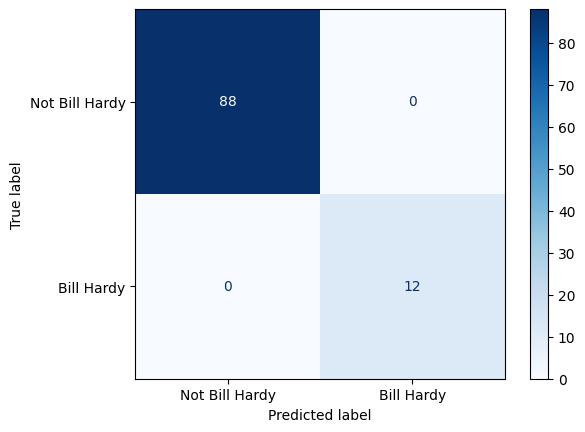

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df.narrator.values, predicted_labels)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Bill Hardy", "Bill Hardy"]
)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues")

plt.show()

Identify misclassified pages

In [22]:
misclassified_indices = [
    i
    for i, (true, pred) in enumerate(zip(df.narrator.values, predicted_labels))
    if true != pred
]

print("Misclassified Sentences:")
for index in misclassified_indices:
    print(
        f"True Label: {int(df.narrator.values[index])} — predicted Label: {predicted_labels[index][0]} — text: {df.text.values[index]}"
    )
    print()

Misclassified Sentences:
